In [1]:
# Check nvidia is working
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
import random
import io
import pickle
import re
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [4]:
from google.colab import drive
import os
from IPython import display

# Define home path.
HOME = os.getcwd()

In [5]:
# Mount Google Drive account
%cd {HOME}
drive.mount('/content/drive')

/content
Mounted at /content/drive


**Load data as dataframe**

Vamos a trabajar con un dataset de alrededor de 2000 canciones de musica folclorica argentina para entrenar un modelo de prediccion del siguiente termino.

In [24]:
df = pd.read_csv("/content/drive/MyDrive/CEIA/nlp/data/songs.csv")

---

**Preprocess text**

In [26]:
def process_text(input_string):
    # Convert the string to lowercase
    processed = input_string.lower()
    # Remove text between parentheses (including the parentheses)
    processed = re.sub(r'\(.*?\)', '', processed)
    # Remove every non-alphanumeric and ' character
    processed = re.sub(r"[^a-zA-Z0-9\s']", '', processed)
    # Replace multiple spaces with a single space
    processed = re.sub(r'\s+', ' ', processed)
    # Remove leading and trailing spaces
    processed = processed.strip()

    return processed

df["lyrics"] = df["lyrics"].apply(process_text)

df.drop_duplicates(inplace=True)

df = df.reset_index(drop=True)

---

**Preprocess sequences**

In [27]:
# Preprocess text with keras
from tensorflow.keras.preprocessing.text import Tokenizer # similar to nltk.ltokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence # similar to nltk.word_tokenize
from tensorflow.keras.utils import pad_sequences # for pad sentences shorter than max length

In [28]:
# Convert pd.Series to list
text = list(df.loc[:, "lyrics"])
text[0]

'estaba el cerro tranquilo cada cual en su trabajo cuando llegaron de abajo tres democratas eternos emisarios del gobierno la lengua como badajo'

In [31]:
# Segment text into list of words
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

# Filter sentences longer than 60 words (to reduce training time for the excercise)
segmented_sentences = [sentence for sentence in segmented_sentences if len(sentence) < 60]

segmented_sentences[0]

['estaba',
 'el',
 'cerro',
 'tranquilo',
 'cada',
 'cual',
 'en',
 'su',
 'trabajo',
 'cuando',
 'llegaron',
 'de',
 'abajo',
 'tres',
 'democratas',
 'eternos',
 'emisarios',
 'del',
 'gobierno',
 'la',
 'lengua',
 'como',
 'badajo']

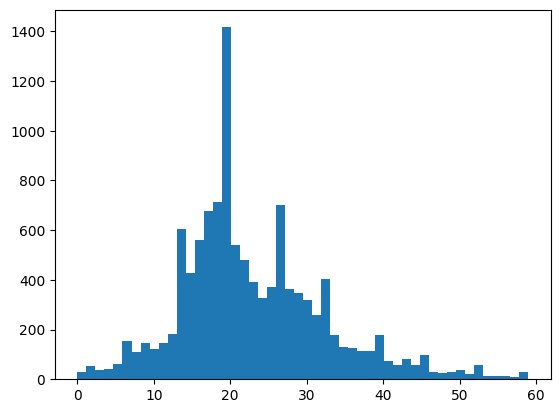

In [32]:
# Get sequences length
length_sentences = [len(sentence) for sentence in segmented_sentences]

# Plot sequences length
plt.hist(length_sentences,bins=50)
plt.show()

In [33]:
# We use the value corresponding to the 90 percentile as max context size.
max_context_size = int(np.percentile(length_sentences, 90) -1) # -1 because the last is the target value

# # Other valid approaches are using mean or median (or any other criterion)
# max_context_size = int(np.ceil(np.mean(length_sentences)))
# max_context_size = int(np.ceil(np.median(length_sentences)))

print(f'max_context_size: {max_context_size}')

max_context_size: 35


---

**Split sequences for train and validation**

In [34]:
segmented_sentences_train, segmented_sentences_val, _, _ = train_test_split(segmented_sentences, segmented_sentences, test_size=0.15, random_state=42)

In [35]:
import json

with open("/content/drive/MyDrive/CEIA/nlp/models/segmented_sentences_train.json", 'w') as file:
    json.dump(segmented_sentences_train, file)

with open("/content/drive/MyDrive/CEIA/nlp/models/segmented_sentences_val.json", 'w') as file:
    json.dump(segmented_sentences_val, file)

In [36]:
len(segmented_sentences_train), len(segmented_sentences_val)

(9750, 1721)

In [37]:
len(segmented_sentences)

11471

---

Should we tokenize just in train set after splitting or in the whole dataset?

In [38]:
# Create and fit the tokenizer with the segmented sentences
tok = Tokenizer()
tok.fit_on_texts(segmented_sentences_train) # token 0: out of vocabulary words

# Tokenize: Convert text to idx
tokenized_sentences_train = tok.texts_to_sequences(segmented_sentences_train)
tokenized_sentences_val = tok.texts_to_sequences(segmented_sentences_val)

tokenized_sentences_train[0]

[12, 730, 1, 4792, 40, 10, 6230, 102, 9233, 529, 3, 60, 770]

In [39]:
import pickle

# saving
with open('/content/drive/MyDrive/CEIA/nlp/models/20241123_model1/tok.pickle', 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # loading
# with open('/content/drive/MyDrive/CEIA/nlp/models/20241122_model/tok.pickle', 'rb') as handle:
#     tok = pickle.load(handle)

# # Tokenize: Convert text to idx
# tokenized_sentences_train = tok.texts_to_sequences(segmented_sentences_train)
tokenized_sentences_val = tok.texts_to_sequences(segmented_sentences_val)

# tokenized_sentences_train[0]

**Explore tokenizer**

In [40]:
vocab_size = len(tok.word_counts)
vocab_size

18512

In [41]:
# Number of individual appearances per word
list(tok.word_counts.items())[:10]

[('un', 2763),
 ('ranchito', 30),
 ('de', 9021),
 ('quincha', 3),
 ('solo', 583),
 ('me', 3079),
 ('ampara', 2),
 ('dos', 230),
 ('alientos', 1),
 ('amigos', 43)]

In [42]:
# Number of documents per word
list(tok.word_docs.items())[:10]

[('la', 4567),
 ('ranchito', 29),
 ('alientos', 1),
 ('luna', 350),
 ('dos', 204),
 ('quincha', 3),
 ('un', 2151),
 ('solo', 519),
 ('de', 5531),
 ('amigos', 38)]

In [43]:
# Idx of each word (ordered by popularity)
print(list(tok.word_index.items())[:10])

[('de', 1), ('que', 2), ('la', 3), ('y', 4), ('el', 5), ('en', 6), ('mi', 7), ('a', 8), ('no', 9), ('me', 10)]


---

**Create train set**

In [44]:
tok_sent = []

max_len = max_context_size + 1 # we include the target
for sent in tokenized_sentences_train:
  # if sequence is longer than max_len, we create many subsequences
  if len(sent) > max_len:
    for i in range(len(sent) - max_len + 1):
      tok_sent.append(sent[i : i + max_len])
  else:
    tok_sent.append(sent)

In [ ]:
# # example code to verify the functionality of the previous chunk
# example_tok_sent = []

# max_len = 8
# for sent in [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]:
#   if len(sent) > max_len:
#     for i in range(len(sent) - max_len + 1):
#       example_tok_sent.append(sent[i : i + max_len])
#   else:
#     example_tok_sent.append(sent)

# print(example_tok_sent)

In [45]:
len(tok_sent)

16605

In [46]:
tok_sent_augm = []

for sent in tok_sent:
  # Generate every possible sub sequence and pad them to max_content_size + 1(target)
  subseq = [
      sent[:i + 2] # i + 2 to have at least 2 valid terms in the first sequence (word + target)
      for i
      in range(0, len(sent) - 1, 3)] # step = 3 to reduce training set~time
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size + 1, padding='pre'))

# The previous step returned a list of list per sequence: concatenate them
train_seqs = np.concatenate(tok_sent_augm, axis=0)

train_seqs.shape

(154567, 36)

In [47]:
train_seqs[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,  12, 730], dtype=int32)

In [48]:
# Get X and y arrays
X = train_seqs[:, :-1]
y = train_seqs[:, -1]

***

**Create the model**

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Initialize the model
model = Sequential()

# Embedding layer:
# - Creates embeddings for vocabulary
# - Adjustable dimensions for better representation
model.add(Embedding(input_dim=vocab_size + 1, output_dim=16, input_shape=(max_context_size,)))

# First and Second Bidirectional LSTM layer:
# - Processes the output from the first layer
# - Return sequences again to allow stacking further layers
model.add(Bidirectional(LSTM(32, return_sequences=True, dropout=0.4, recurrent_dropout=0.2)))
# model.add(Bidirectional(LSTM(32, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)))

# Third LSTM layer (unidirectional):
# - Reduces dimensionality
# - Does not return sequences
model.add(LSTM(32, dropout=0.4))

# Fully connected layer:
# - Adds a dense layer for high-level feature learning
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))  # Adds regularization

# Output layer:
# - Outputs probabilities for each class (softmax activation)
# - Matches the vocabulary size for word prediction
model.add(Dense(vocab_size + 1, activation='softmax', kernel_regularizer=l2(0.01)))

# Compile the model:
# - Sparse categorical crossentropy is used to handle integer-encoded targets
model.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 35, 16)              │         296,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 35, 64)              │          12,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 18513)               │         314,721 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 636,417 (2.43 MB)

 Trainable params: 636,417 (2.43 MB)

 Non-trainable params: 0 (0.00 B)

**Load previous model to continue training**

In [53]:
# from tensorflow.keras.models import load_model

# # Load the saved model (replace the path with the correct file)
# model = load_model('/content/drive/MyDrive/CEIA/nlp/models/20241123_model/model.keras')

---

**Train model**

In [50]:
np.savetxt('/content/drive/MyDrive/CEIA/nlp/models/X_train.txt', X, fmt='%d')
np.savetxt('/content/drive/MyDrive/CEIA/nlp/models/y_train.txt', y, fmt='%d')

# b = np.loadtxt('test1.txt', dtype=int)

In [51]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    '''

    def __init__(self, val_data):
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []

      for seq in self.val_data:
        len_seq = len(seq)
        if len(seq) < 2:
          continue

        # We create all possible subsequences
        subseq = [seq[:i] for i in range(1, len_seq)]
        self.target.extend(seq[1:])
        self.padded.append(pad_sequences(subseq, maxlen = max_context_size, padding='pre'))

        self.info.append((count, count + (len_seq - 1)))
        count += (len_seq - 1)

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):
        scores = []
        predictions = self.model.predict(self.padded, verbose=0)

        predictions = np.clip(predictions, 1e-10, 1-1e-10) # Clip predictions to avoid log(0)

        # Calculate perplexity score for each term
        for start, end in self.info:
            probs = [predictions[idx_seq, idx_vocab] for idx_seq, idx_vocab in zip(range(start, end), self.target[start : end])]
            scores.append(np.exp(-np.mean(np.log(probs))))

        # Calcualte mean perplexity
        mean_ppl = np.mean(scores)
        print(f'\n mean perplexity: {mean_ppl} \n')

In [ ]:
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint

# Define a callback to save the model every 5 epochs
save_every_n_epochs = LambdaCallback(on_epoch_end=lambda epoch, logs:
                                     model.save(f'/content/drive/MyDrive/CEIA/nlp/models/model_epoch_{epoch + 1}.keras', include_optimizer=True)
                                     if (epoch + 1) % 1 == 0 else None)

# Train the model with the custom callback
hist = model.fit(
    X,
    y,
    epochs=50,
    callbacks=[
        PplCallback(tokenized_sentences_val),  # Your existing callback
        save_every_n_epochs                   # Save model every 5 epochs
    ],
    batch_size=64
)

    Epoch 1/50
    2415/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.0360 - loss: 9.0349
    mean perplexity: 1446.8643798828125

    Epoch 2/50
    2415/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.0396 - loss: 7.5174
    mean perplexity: 1356.2362060546875

    Epoch 3/50
    2415/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.0397 - loss: 7.3744
    mean perplexity: 1327.3463134765625

    Epoch 4/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.0395 - loss: 7.3188
    mean perplexity: 1291.9498291015625

    Epoch 5/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.0399 - loss: 7.2244
    mean perplexity: 1288.92822265625

    Epoch 6/50
    2415/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.0405 - loss: 7.1734
    mean perplexity: 1282.300048828125

    Epoch 7/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.0403 - loss: 7.1300
    mean perplexity: 1288.3594970703125

    Epoch 8/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.0409 - loss: 7.1032
    mean perplexity: 1292.248046875

    Epoch 9/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.0408 - loss: 7.0814
    mean perplexity: 1299.22216796875

    Epoch 10/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.0393 - loss: 7.0605
    mean perplexity: 1319.4664306640625

    Epoch 11/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.0404 - loss: 7.0256
    mean perplexity: 1327.1043701171875

    Epoch 12/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.0413 - loss: 7.0217
    mean perplexity: 1345.6363525390625

    Epoch 13/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.0407 - loss: 6.9970
    mean perplexity: 1371.47900390625

In [ ]:
# Reload best model
model = load_model('./../models/best_model.keras')

# Recompile the model with the new optimizer
# Should have saved optimizer state!
model.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(learning_rate=0.00003),
    metrics=['accuracy']
)

# Retrain the model with the lower learning rate
hist = model.fit(
    X,
    y,
    epochs=50,
    callbacks=[
        PplCallback(tokenized_sentences_val),  # Your existing callback
        save_every_n_epochs                   # Save model every 5 epochs
    ],
    batch_size=64
)

    Epoch 1/50
    2415/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.0402 - loss: 7.1441
    mean perplexity: 1300.7794189453125

    Epoch 2/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0408 - loss: 7.1398
    mean perplexity: 1291.698974609375

    Epoch 3/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0408 - loss: 7.1261
    mean perplexity: 1292.546630859375

    Epoch 4/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0396 - loss: 7.1203
    mean perplexity: 1294.7169189453125

    Epoch 5/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.0409 - loss: 7.0991
    mean perplexity: 1290.9434814453125

    Epoch 6/50
    2415/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0407 - loss: 7.0957
    mean perplexity: 1289.7471923828125

    Epoch 7/50
    2415/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.0406 - loss: 7.0782
    mean perplexity: 1296.2232666015625

    Epoch 8/50
    2415/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0397 - loss: 7.0751
    mean perplexity: 1299.64990234375

    Epoch 9/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.0410 - loss: 7.0653
    mean perplexity: 1302.5528564453125

    Epoch 10/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0398 - loss: 7.0735
    mean perplexity: 1305.4849853515625

In [ ]:
# Reload best model
model = load_model('./../models/best_model.keras')

# Recompile the model with the new optimizer
# Should have saved optimizer state!
model.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(learning_rate=0.00001),
    metrics=['accuracy']
)

# Retrain the model with the lower learning rate
hist = model.fit(
    X,
    y,
    epochs=50,
    callbacks=[
        PplCallback(tokenized_sentences_val),  # Your existing callback
        save_every_n_epochs                   # Save model every 5 epochs
    ],
    batch_size=64
)

    Epoch 1/50
    2415/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.0397 - loss: 7.1501
    mean perplexity: 1298.7662353515625

    Epoch 2/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0409 - loss: 7.1265
    mean perplexity: 1296.0526123046875

    Epoch 3/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0409 - loss: 7.1437
    mean perplexity: 1295.7974853515625

    Epoch 4/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0401 - loss: 7.1375
    mean perplexity: 1293.6080322265625

    Epoch 5/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.0407 - loss: 7.1347
    mean perplexity: 1294.9107666015625

    Epoch 6/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.0408 - loss: 7.1304
    mean perplexity: 1295.7454833984375

    Epoch 7/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0409 - loss: 7.1180
    mean perplexity: 1294.0455322265625

    Epoch 8/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.0414 - loss: 7.1190
    mean perplexity: 1293.0714111328125

    Epoch 9/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0407 - loss: 7.1065
    mean perplexity: 1292.416748046875

    Epoch 10/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.0409 - loss: 7.1076
    mean perplexity: 1293.7235107421875

    Epoch 11/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.0414 - loss: 7.1036
    mean perplexity: 1292.7979736328125

    Epoch 12/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0404 - loss: 7.0940
    mean perplexity: 1292.5150146484375

    Epoch 13/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0414 - loss: 7.0985
    mean perplexity: 1292.34521484375

    Epoch 14/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0399 - loss: 7.0878
    mean perplexity: 1292.7373046875

    Epoch 15/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0418 - loss: 7.0872
    mean perplexity: 1291.9837646484375

    Epoch 16/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.0403 - loss: 7.0881
    mean perplexity: 1292.9183349609375

    Epoch 17/50
    2415/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.0410 - loss: 7.0865
    mean perplexity: 1293.0306396484375

    Epoch 18/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.0408 - loss: 7.0797
    mean perplexity: 1294.1676025390625

    Epoch 19/50
    2415/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0398 - loss: 7.0794
    mean perplexity: 1294.05810546875

    Epoch 20/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.0411 - loss: 7.0828
    mean perplexity: 1294.3927001953125

    Epoch 21/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0408 - loss: 7.0656
    mean perplexity: 1294.4691162109375

    Epoch 22/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.0405 - loss: 7.0654
    mean perplexity: 1295.6854248046875

    Epoch 23/50
    2415/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0410 - loss: 7.0790
    mean perplexity: 1297.6031494140625

    Epoch 24/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0408 - loss: 7.0695
    mean perplexity: 1297.6300048828125

    Epoch 25/50
    2416/2416 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0406 - loss: 7.0774
    mean perplexity: 1297.540283203125

---

**Test the best model**

We select the model trained after epoch 6 in the first case which obtained the following metrics:

    train accuracy: 0.0405
    train loss: 7.1734
    val mean perplexity: 1282.300048828125

In [ ]:
import pickle

from IPython import display

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import load_model


model = load_model('./../models/best_model.keras')

with open('./../data/artifacts/tok.pickle', 'rb') as handle:
    tok = pickle.load(handle)

max_context_size = 35

**Basic generator**

In [190]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [191]:
input_text='chacarera'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


'chacarera de de de de de de de de de de'

La inferencia deterministica elige siempre el termino mas representado en el set de entrenamiento. Vamos a probar usando beam search y muestreo aleatorio.

**Beam search y muestreo aleatorio**

In [192]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [266]:
from scipy.special import softmax

def select_candidates(pred, num_beams, vocab_size, history_probs, history_tokens, temp=1):
  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []
  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10) + history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  idx_select = np.random.choice(
      np.arange(pred_large.shape[0]),
      num_beams,
      p = softmax(pred_large / temp)
      ) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model, num_beams, num_words, input, temp):
    encoded = encode(input)
    y_hat = np.squeeze(model.predict(encoded))

    vocab_size = y_hat.shape[0]

    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates(
        pred = [y_hat],
        num_beams = num_beams,
        vocab_size = vocab_size,
        history_probs = history_probs,
        history_tokens = history_tokens,
        temp = temp
    )

    # beam search loop
    for i in range(num_words - 1):
      preds = []
      for hist in history_tokens:
        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()
        # predicción
        y_hat = np.squeeze(model.predict(input_update))
        preds.append(y_hat)
      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens)
    return history_tokens

In [ ]:
input = "cuando pienso en"

salidas = []
for i in range(10):
    salida = beam_search(
        model,
        num_beams=10,
        num_words=6,
        input=input,
        temp=1
    )

    salidas.append(salida)
    display.clear_output()

for salida in salidas:
    print(decode(salida[0]))

    ['cuando pienso en que tu soy de si vidalitass']
    ['cuando pienso en amor que en la paloma iguana']
    ['cuando pienso en y que solo a en coloradas']
    ['cuando pienso en que que de en y de']
    ['cuando pienso en amor es de el no soy']
    ['cuando pienso en de que a y en me']
    ['cuando pienso en el pero la con mi con']
    ['cuando pienso en el la es y de traia']
    ['cuando pienso en ni en el y para pero']
    ['cuando pienso en que del un a luz con']

Vemos que algunas pocas de las frases generadas tienden a tener cohesion, sin embargo vemos la repeticion constante de algunos terminos cortos (articulos y preposiciones principalmente). Vamos a ver a que se debe.

In [255]:
encoded = encode(input)
y_hat = np.squeeze(model.predict(encoded))

idx = np.argsort(y_hat)[::-1][:20]
idx

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


array([ 1,  2,  3,  4,  5,  6,  8,  7, 12,  9, 11, 10, 15, 14, 17, 13, 16,
       19, 18, 22])

Vemos que los terminos mas probables para nuestro input, y posiblemente para todos los que intentemos, son las palabras mas repetidas del tokenizador, es decir los indices menores (a excepcion del 0 que se reserva para vocablos no vistos en training).

Puede ser de utilidad entonces incrementar la temperatura para que aparezcan terminos diferentes, pero sin excedernos en el valor para que las frases tiendan a conservar el sentido.

In [ ]:
input = "cuando pienso en"
temp = 1.5

salidas = []
for i in range(10):
    salida = beam_search(
        model,
        num_beams=10,
        num_words=6,
        input=input,
        temp=temp
    )

    salidas.append(salida)
    display.clear_output()

for salida in salidas:
    print(decode(salida[0]))

    ['cuando pienso en las cancion en no la fe']
    ['cuando pienso en y que en de no embriagara']
    ['cuando pienso en sin corazon que su sus recordarlas']
    ['cuando pienso en esta por y y sus siempe']
    ['cuando pienso en tu hay de yo volver con']
    ['cuando pienso en el que lo no de cocido']
    ['cuando pienso en la con la como de una']
    ['cuando pienso en pero y de en en si']
    ['cuando pienso en ser en la pero de dormiremos']
    ['cuando pienso en de de la que mi peliar']

Se siguen percibiendo terminos cortos y repetidos.

In [ ]:
input = "cuando pienso en"
temp = 2

salidas = []
for i in range(10):
    salida = beam_search(
        model,
        num_beams=10,
        num_words=6,
        input=input,
        temp=temp
    )

    salidas.append(salida)
    display.clear_output()

for salida in salidas:
    print(decode(salida[0]))

    ['cuando pienso en en el de el se nadie']
    ['cuando pienso en estrella es de de desde cuando']
    ['cuando pienso en pasar que es que en vivo']
    ['cuando pienso en en amor no va de amenaza']
    ['cuando pienso en mi para a de se eres']
    ['cuando pienso en otra al con o la acorte']
    ['cuando pienso en yo es es el casa las']
    ['cuando pienso en decencia que el dolor que pico']
    ['cuando pienso en sur con te de inutilmente chamarra']
    ['cuando pienso en catedral por de a hombre hiciste']

Utilizando un patron de temperatura igual a 2 vemos una mejor relacion entre terminos y articulos. Incluso algunas de las oraciones muestran una cohesion decente.

In [ ]:
input = "cuando pienso en"
temp = 3

salidas = []
for i in range(10):
    salida = beam_search(
        model,
        num_beams=10,
        num_words=6,
        input=input,
        temp=temp
    )

    salidas.append(salida)
    display.clear_output()

for salida in salidas:
    print(decode(salida[0]))

    ['cuando pienso en vi de no cuando el y']
    ['cuando pienso en vengo en y y por pago']
    ['cuando pienso en vita y que tengo en es']
    ['cuando pienso en los yo en hay la de']
    ['cuando pienso en llame mi es y se otra']
    ['cuando pienso en paseado mis yo mi que sus']
    ['cuando pienso en secreto en se emocion sin martes']
    ['cuando pienso en eran que que que que un']
    ['cuando pienso en salio el y las su pruebas']
    ['cuando pienso en vaca a que que el acullico']

Con un valor de temperatura igual a 3 vemos que las oraciones pierden toda cohesion. Por lo que observamos, el mejor valor de temperatura es 2 para nuestro caso.

---

**Conclusion**

Si bien el tamano de nuestro dataset se encuentra limitado por la capacidad de computo que podemos alcanzar, el entrenamiento a resultado un buen ejercicio para evaluar diferentes arquitecturas e hiperparametros para evitar el sobre-ajuste del modelo.

La evaluacion de resultados arroja que el modelo tiende a priorizar preposiciones y articulos que se repiten constantemente en los documentos. Quizas para evitar esto se deberia buscar entrenar el modelo con un mejor equilibrio entre palabras cortas y largas en los documentos utilizados. O de algun modo priorizar terminos apareciendo mas esporadicamente durante el entrenamiento. Sin embargo, podemos observar un desempeno minimamente aceptable en algunas de las oraciones generados con un valor de temperatura igual a 2 (lo cual permite equilibrar un poco las probabilidades de los terminos y compensar la sobrerepresentacion de terminos cortos).